In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd

from timeit import default_timer as timer
import random

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
#from sklearn.preprocessing import OrdinalEncoder
#enc = OrdinalEncoder()

#from contextlib import redirect_stdout

# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [64, 128, 224] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'

In [96]:
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)

In [11]:
# Loss function for gradcam


In [97]:
def plotGradCAM(model, scenario, image_size, images_per_class = 4, trial_seed = 1, testing=True):
    #ALT: use train_test_split
#    trimg,vaimg,trlab,valab =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[64]["Pr_Im"]]), 
#                 np.array([x[1] for x in image_sets[64]["Pr_Im"]]), stratify= np.array([x[1] for x in image_sets[64]["Pr_Im"]]), test_size=.2, random_state = 1  )

    training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = trial_seed)
    training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
    validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)
    print(training_labels.sum(axis=0))
    print(validation_labels.sum(axis=0))    
    
    
    # GRAD CAM
    random.seed(trial_seed)
    # Randomly sample images from each class
    random_image_selection_class_0 = random.choices([i for i, j in enumerate(validation_labels) if np.argmax(j) == 0], k = images_per_class)    
    random.seed(trial_seed+1)
    random_image_selection_class_1 = random.choices([i for i, j in enumerate(validation_labels) if np.argmax(j) == 1], k = images_per_class)
    assert validation_labels[random_image_selection_class_0].mean(axis=0)[0] == 1 #assert that indices of class 0 labels are correct
    assert validation_labels[random_image_selection_class_1].mean(axis=0)[1] == 1 #assert that indices of class 1 labels are correct
    cam_list = random_image_selection_class_0 + random_image_selection_class_1 # join lists of indices in both classes
    if scenario=="Pr_Po_Im": # in 3-class case
        random.seed(trial_seed+2)
        random_image_selection_class_2 = random.choices([i for i, j in enumerate(validation_labels) if np.argmax(j) == 2], k = images_per_class)    
        cam_list = cam_list + random_image_selection_class_2 # join to prior list of class 0 and class 1
        assert validation_labels[random_image_selection_class_2].mean(axis=0)[2] == 1 #assert that indices of class 2 labels are correct

    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print(output)
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_list] ])]
        return loss_list

    # Model_modifier function required for gradcam
    def model_modifier(m):
        """Remove softmax activation of last layer in model"""
        m.layers[-1].activation = tf.keras.activations.linear
        return m

    # subset validation images to use for gradcam
    print("List of indices from validation images:", cam_list)
    gradcam_images = validation_images[cam_list] #tf.convert_to_tensor(validation_images[cam_list], dtype= tf.float32)
    print("Shape of gradcam image array:", gradcam_images.shape)
    print([np.argmax(j) for j in validation_labels[cam_list] ])

    # Create Gradcam object
    gradcam = Gradcam(model, model_modifier = model_modifier)#, clone=False)

    # Generate heatmap with GradCAM
    subplot_args = { 'nrows': len(class_labels), 'ncols': images_per_class, 'figsize': (3*images_per_class,3*len(class_labels)), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }    
    cam = gradcam(loss, gradcam_images, penultimate_layer = -1)
    cam = normalize(cam)
    print(len(cam))
    f, ax = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    image_counter = 0
    for i, label in enumerate(class_labels):
        ax[i,0].set_ylabel(label, fontsize=14)
        for j in np.arange(images_per_class):
            print(i, j, image_counter)
            heatmap = np.uint8(cm.jet(cam[image_counter])[..., :3] * 255)            
            ax[i, j].imshow(gradcam_images[image_counter], cmap='gist_gray')
            ax[i, j].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
            image_counter += 1
    plt.tight_layout()
    #plt.show()
    if testing==True:
        f.savefig("../../figures/test-opt-gradcam-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    else:
        f.savefig("../../figures/opt-gradcam-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    return

In [2]:
m = models.load_model('../../results/models/opt-cnn-Pr_Im-224-px/model')

In [9]:
m.count_params(t)

<bound method Layer.count_params of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa941489a60>>

Class labels: ['Probable', 'Improbable']
[ 453 1247]
[102 323]
List of indices from validation images: [86, 381, 344, 401, 399, 20]
Shape of gradcam image array: (6, 224, 224, 1)
[0, 0, 0, 1, 1, 1]
tf.Tensor(
[[ 5.9008827 -4.605936 ]
 [ 4.4310656 -3.08227  ]
 [ 2.9336448 -2.0222886]
 [-4.192129   4.847603 ]
 [-4.2154627  4.234721 ]
 [-3.2246912  5.061093 ]], shape=(6, 2), dtype=float32)
6
0 0 0
0 1 1
0 2 2
1 0 3
1 1 4
1 2 5


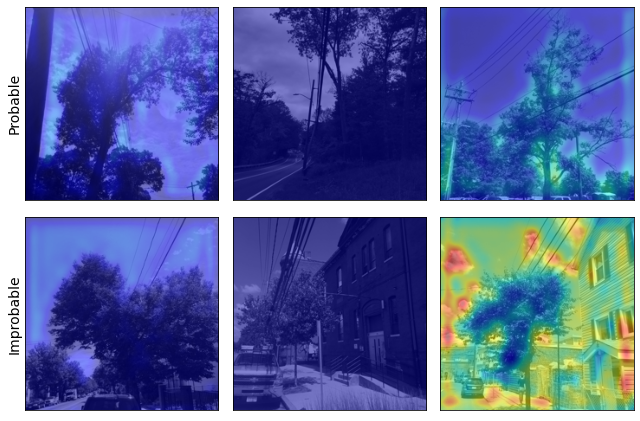

In [103]:
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
plotGradCAM(m, "Pr_Im", 224, images_per_class = 3, trial_seed = 1,  testing=True)

In [ ]:
def plotSaliency(model, scenario, image_size, images_per_class = 4, trial_seed = 1, saliency=False, testing=True):
    training_images_and_labels, test_images_and_labels = splitData(image_sets[image_size][scenario], prop = 0.8, seed_num = trial_seed)
    training_images, training_labels = getImageAndLabelArrays(training_images_and_labels)
    validation_images, validation_labels = getImageAndLabelArrays(test_images_and_labels)
    class_labels = getClassLabels(scenario)
    print("Class labels:", class_labels)
    print(training_labels.sum(axis=0))
    print(validation_labels.sum(axis=0))    
    
    # GRAD CAM
    random.seed(trial_seed)
    # Randomly sample images from each class
    random_image_selection_class_0 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 0], k = images_per_class)    
    random.seed(trial_seed+1)
    random_image_selection_class_1 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 1], k = images_per_class)
    assert validation_labels[random_image_selection_class_0].mean(axis=0)[0] == 1 #assert that indices of class 0 labels are correct
    assert validation_labels[random_image_selection_class_1].mean(axis=0)[1] == 1 #assert that indices of class 1 labels are correct
    cam_list = random_image_selection_class_0 + random_image_selection_class_1 # join lists of indices in both classes
    if scenario=="Pr_Po_Im": # in 3-class case
        random.seed(trial_seed+2)
        random_image_selection_class_2 = random.sample([i for i, j in enumerate(validation_labels) if np.argmax(j) == 2], k = images_per_class)    
        cam_list = cam_list + random_image_selection_class_2 # join to prior list of class 0 and class 1
        assert validation_labels[random_image_selection_class_2].mean(axis=0)[2] == 1 #assert that indices of class 2 labels are correct
    # subset validation images to use for gradcam
    print("List of indices from validation images:", cam_list)
    gradcam_images = validation_images[cam_list] #tf.convert_to_tensor(validation_images[cam_list], dtype= tf.float32)
    print("Shape of gradcam image array:", gradcam_images.shape)
    print([np.argmax(j) for j in validation_labels[cam_list] ])

    subplot_args = { 'nrows': len(class_labels), 'ncols': images_per_class, 'figsize': (3*images_per_class,3*len(class_labels)), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }    

    saliency = Saliency(model, model_modifier=model_modifier)#                    clone=False)

    # Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(loss, gradcam_images, 
                            smooth_samples=20, # The number of calculating gradients iterations.
                            smooth_noise=0.20) # noise spread level.
    saliency_map = normalize(saliency_map)
    #image_titles = class_labels
    f, ax = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    image_counter = 0
    for i, label in enumerate(class_labels):
        ax[i,0].set_ylabel(label, fontsize=14)
        for j in np.arange(images_per_class):
            print(i, j, image_counter)
            ax[i, j].imshow(saliency_map[image_counter], cmap='jet', alpha=0.5) # overlay
            image_counter += 1
    plt.tight_layout()
    #plt.show()
    if testing == True:
        f.savefig("../../figures/test-opt-saliency-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
    else:
        f.savefig("../../figures/opt-saliency-" + scenario + "-" + str(image_size) + "-px-" + str(images_per_class) + "-images.png")
return



Steps: 050	Losses: [[3201.8212890625]],	Regularizations: [[('TotalVariation', 175.47457885742188), ('L2Norm', 0.07119499146938324)]]
Steps: 100	Losses: [[2636.000244140625]],	Regularizations: [[('TotalVariation', 190.968505859375), ('L2Norm', 0.06719645112752914)]]
Steps: 150	Losses: [[3142.21533203125]],	Regularizations: [[('TotalVariation', 187.51467895507812), ('L2Norm', 0.06409506499767303)]]
Steps: 200	Losses: [[319.58306884765625]],	Regularizations: [[('TotalVariation', 211.11854553222656), ('L2Norm', 0.06137976795434952)]]


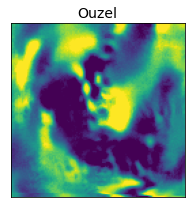

In [75]:
from tf_keras_vis.activation_maximization import ActivationMaximization

def model_modifier(m):
    """Remove softmax activation of last layer in model"""
    m.layers[-1].activation = tf.keras.activations.linear
    return m

activation_maximization = ActivationMaximization(m,
                                                 model_modifier)
                                                 
def loss(output):
    return output[:, 0]


from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss,
                                     callbacks=[Print(interval=50)])
image = activation[0].astype(np.uint8)

subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
ax.set_title('Ouzel', fontsize=14)
plt.tight_layout()
plt.show()

